# Climatology

## Overview
The climato method from the lntime module enables regression of a signal from a dataset:
 - on annual or semi-annual cycles
 - on polynomials of any order
 - on any user-defined function

It returns an instance of the *Coeffs_climato* class.


The time sampling can be arbitrary.

Basically, the climato method solves a least squares problem **Y = A.X**, where **Y** is a time-dependent signal and **X** is a matrix of defined temporal functions (annual cycle, mean, trend, acceleration, arbitrary functions, etc.). **A** thus contains the coefficients to apply to each of these temporal functions to minimize the residuals **Y - A.X**.

Input dataset format
 - One dimension must correspond to time. The time variable does not necessarily need to be a coordinate; it can be a variable in the dataset.
 - There can be any number of dimensions independent of time (latitude, longitude, depth, models, etc.).


## Coeffs_climato Class
### Initialisation
```python
clim = Coeffs_climato(ds, dim='time', var=None, Nmin=6, cycle=True, order=1)
```
- **ds**: dataset or dataarray containing the data  
- **dim**: name of the dimension over which to perform the regressions  
- **var**: name of the variable or coordinate containing time information. If None, `var = dim`  
- **Nmin**: minimum number of valid data points required to compute the coefficients. This number is added to the number of regression functions. For example, if `Nmin=0` and you're computing annual and semi-annual cycles, trend, and mean, you need at least 6 valid points; otherwise, the coefficients will be set to NaN.  
- **cycle**: use annual and semi-annual cycle functions by default  
- **order**: polynomial order for regression. If `order = -1`, no polynomial regression is applied.

### Adding custom functions:
```python
clim.add_coeffs(coefficients, func, *var, ref=None, scale=pd.to_timedelta("1D").asm8, **kwargs)
```
- **coefficients**: names of the coefficients corresponding to the output of the `func` function  
- **func**: function that takes a time series as input and returns a dataarray  
- **var**: variables passed as parameters to the `func`  
- **ref**: temporal origin used in computing the function  
- **scale**: time scaling used in computing the function  
- **kwargs**: additional parameters passed to the function

**The computed function is actually evaluated as**: `func((x - ref) / scale)`

### Coefficient computation:
```python
coeffs = clim.solve(measure=None, chunk=None, weight=None, t_min=None, t_max=None)
```
- **measure**: name of the variable in the input dataset `ds` for which to compute the climatology. If the input is a dataArray, leave this blank.  
- **chunk**: enables parallel processing for large datasets with multiple dimensions  
- **weight**: weighting matrix for the least squares computation. If `None`, all measurements are equally weighted  
- **t_min, t_max**: start and end times for the climatology calculation. If `None`, no time limit is applied.  

**This method returns an instance of the *Signal_climato* class.**
  
## Signal_climato Class
This class is used to work with climatological coefficients. It is returned by the *solve* method from the *Coeffs_climato* class, but can also be constructed from previously saved coefficients. In that case, it must be properly initialized with all the parameters of the functions used to perform the regression.

### Initialization
```python
signal = Signal_climato(coeffs, dim='time', var=None, cycle=True, order=1, ref=None, ds=None, measure=None)
```
- **coeffs**: coefficients computed by the *Coeffs_climato* class  
- **dim**: name of the dimension over which to perform the regressions  
- **var**: name of the variable or coordinate containing time information. If None, `var = dim`  
- **cycle**: use of annual and semi-annual cycle functions by default  
- **order**: polynomial order for regression. If `order = -1`, no polynomial regression  
- **ref**: default reference for built-in functions (annual cycle and polynomial)  
- **ds**: dataset or dataarray used for coefficient computation (optional; only used for residual or interpolation calculations)  
- **measure**: if `ds` is defined and is a dataset, name of the variable containing the measurements used to compute the coefficients  


### Adding custom functions:
Same method as for coefficient calculation. These functions must be defined in a way that is consistent with those used during coefficient computation.  
Unnecessary when the instance is obtained from the *solve* method of the *Coeffs_climato* class.

### Outputs
```python
signal.climatology(coefficients=None, x=None) :
```
Regressed climatological function
- **coefficients**: names of coefficients to include in the output time series. If `None`, all coefficients are used  
- **x**: time points for computation. If `None`, time values from the input dataset are used (`x = ds.var`)

```python
signal.residuals(coefficients=None)
```
Residuals between measurements and the regressed climatological function  
- **coefficients**: names of coefficients to consider for residuals calculation. If `None`, all coefficients are used  

```python
signal.signal(x=None, coefficients=None, method='linear')
```
Signal combining interpolated residuals and the regressed climatological function. If residuals contain NaNs, they are interpolated using the chosen method  
- **x**: time points for computation. If `None`, time values from the input dataset are used (`x = ds.var`)  
- **coefficients**: names of coefficients to consider. If `None`, all are used  
- **method**: interpolation method for calculation times and NaN values, from `scipy.interp1d` options


In [1]:
import lenapy
import xarray as xr
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lenapy.constants import *


## Example on a Simple Time Series

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 216, latitude: 30, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2005-01-14T23:46:17.343750 ... 2022-...
  * latitude   (latitude) float64 240B 30.5 31.5 32.5 33.5 ... 57.5 58.5 59.5
  * longitude  (longitude) float64 240B -29.5 -28.5 -27.5 ... -2.5 -1.5 -0.5
Data variables:
    ohc        (time, latitude, longitude) float64 2MB ...
    gohc       (time) float64 2kB ...

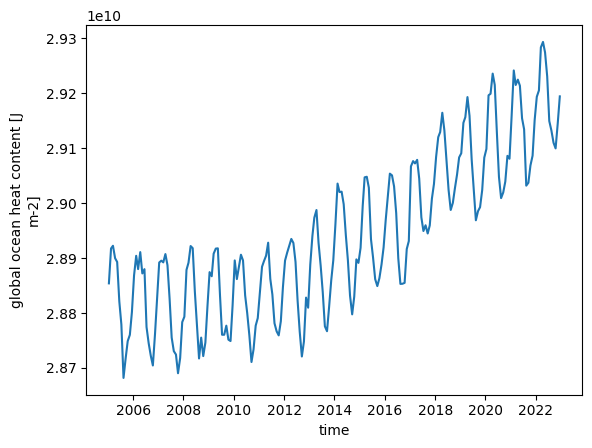

In [2]:
moheacan=xr.open_dataset('../../data/ohc.nc')
moheacan.gohc.plot()
moheacan

## Calling the Climato Class
By default, the regression functions are the annual cycle, the semi-annual cycle, the mean, and the trend.


In [3]:
clim=moheacan.gohc.lntime.Coeffs_climato()
clim.coeff_names

['cosAnnual',
 'sinAnnual',
 'cosSemiAnnual',
 'sinSemiAnnual',
 'order_0',
 'order_1']

## Calculation of Climatology Coefficients on a Dataset Variable
First, the climatology must be calculated by specifying the variable in the input dataset that contains the measurements.


In [4]:
clim_gohc=clim.solve()

## Calculation of the Corresponding Climate Signal
The `climatology` method returns the different components of the climate signal. If nothing is specified, the sum of all components is computed. Otherwise, the `coefficients` parameter should contain a list of the names of the coefficients to return.

The climate signal can be computed at time steps different from those of the original signal. To do this, pass a dataset or data array to the `x` argument that includes all the variables required to compute the fitted functions. Typically, `'time'` is sufficient.


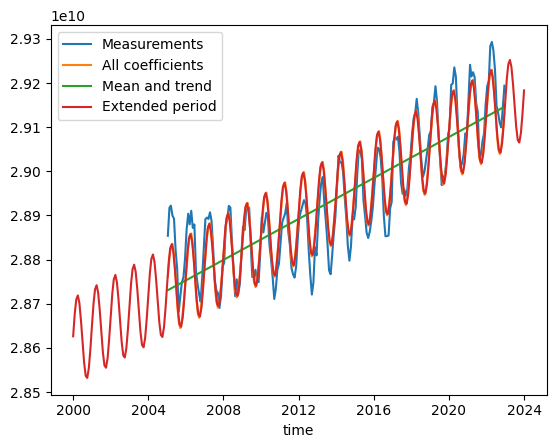

In [5]:
moheacan.gohc.plot(label='Measurements')
clim_gohc.climatology().plot(label='All coefficients')
clim_gohc.climatology(coefficients=['order_0','order_1']).plot(label='Mean and trend')
t_new=xr.DataArray(pd.date_range('2000','2024',freq='1MS'),dims=['time'])
clim_gohc.climatology(x=t_new,coefficients=['order_0','order_1','cosAnnual','sinAnnual']).plot(label='Extended period')

plt.legend()

Climatology can be computed over a restricted period by using the `t_min` and `t_max` parameters.

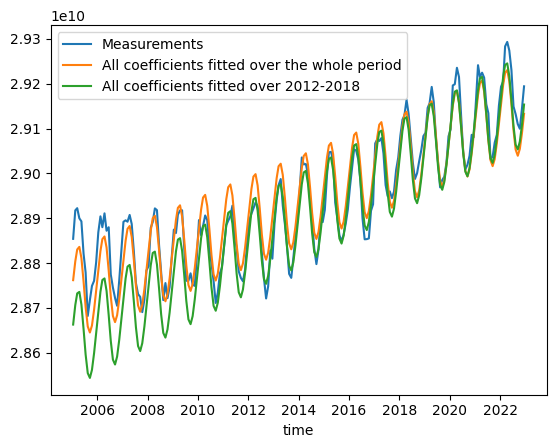

In [6]:
moheacan.gohc.plot(label='Measurements')
clim.solve('gohc').climatology().plot(label='All coefficients fitted over the whole period')
clim.solve('gohc',t_min='2012',t_max='2018').climatology().plot(label='All coefficients fitted over 2012-2018')

plt.legend()

## Using custom fit functions

The functions to be fitted are called by applying a reference and scaling to the input data: *func((t - tref) / scale)*

The default functions for annual and semi-annual cycles, mean, and trend used when instantiating the `Climato` class apply the first date of the time series as the reference, and use a scaling so that the time unit is one day.

To use different references, scalings, or entirely different functions to fit, you must specify which default functions to exclude at instantiation (*cycle* or *order*), then manually add the functions to fit.  
To add a function, there are two options:

- Using one of the two functions instantiated in the `Climato` class:
  - *poly(order, ref, scale)*: creates a polynomial function of the chosen order, with optional reference and scaling.
  - *cycle(ref)*: generates annual and semi-annual cycles, with optional reference.

- Using the `add_coeffs` method to define a custom function:
  - First, define a function of one or more variables that returns a DataArray with two dimensions:
    - One dimension matching that of the dataset used for climatology computation (most commonly `'time'`),
    - Another called `'coeffs'`, allowing multiple functions to be returned in a single call.

  The function should have the form *func(p1, p2, p3, ...)*, and will be called as *func((p1 - ref) / scale, p2, p3, ...)*

  - Assign this function to the `Climato` instance using the *add_coeffs(coefficients, func, *args, ref, scale)* method:
    - *coefficients*: list of component names for the function to be fitted (*sinAnnual*, *trend*, *acc*, ... of your choice).
    - *func*: the previously defined function.
    - *args*: one or more names of the dataset variables that are function parameters (usually *time*, but can be any variable).
    - *ref* and *scale*: reference and scaling, **applied only to the first argument of the function**. By default, *ref* is the minimum value of the variable, and *scale* is `pd.to_timedelta("1D").asm8` (i.e., 1 day).


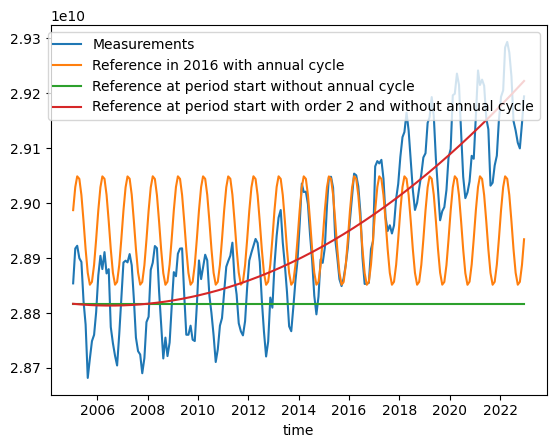

In [10]:
moheacan.gohc.plot(label='Measurements')

clim=moheacan.lntime.Coeffs_climato(cycle=True,order=2,ref=pd.to_datetime('2016').asm8)
clim_gohc = clim.solve('gohc')
clim_gohc.climatology(coefficients=['order_0','cosAnnual','sinAnnual']).plot(label='Reference in 2016 with annual cycle')

clim=moheacan.lntime.Coeffs_climato(cycle=False,order=2)
clim_gohc=clim.solve('gohc')
clim_gohc.climatology(coefficients=['order_0']).plot(label='Reference at period start without annual cycle')
clim_gohc.climatology(coefficients=['order_0','order_1','order_2']).plot(label='Reference at period start with order 2 and without annual cycle')

plt.legend()

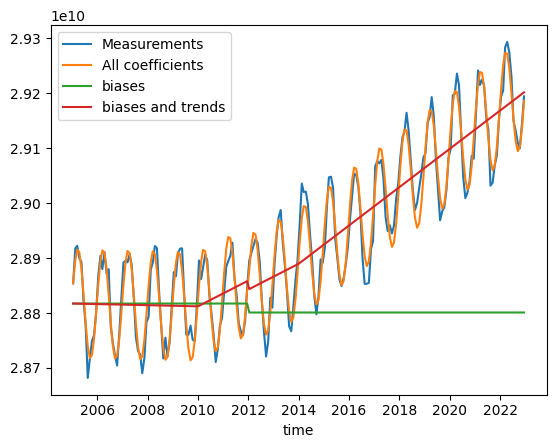

In [13]:
# Example of the Default Implemented Functions:
omega=2*np.pi/LNPY_DAYS_YEAR

def annual(x):
    return xr.concat((np.cos(omega*x),np.sin(omega*x)),dim="coeffs")

def semiannual(x):
    return xr.concat((np.cos(2*omega*x),np.sin(2*omega*x)),dim="coeffs")

def pol(x,order=1):
    return  x**xr.DataArray(np.arange(order+1),dims='coeffs')

# Example of a Function to Add a Second Trend and a Bias Starting from a Given Date:
def trend(x):
    return xr.where(x<0,0,x)

def bias(x):
    return xr.where(x<0,0,1.)
    
# Adding Functions to Fit to the Climato Instance
clim=moheacan.lntime.Coeffs_climato(cycle=False,order=1)
# Annual cycle 
clim.add_coeffs(['cosAnnual','sinAnnual'],annual,'time')
# Second biais since 2012
clim.add_coeffs('bias2',bias,'time',ref=pd.to_datetime('2012').asm8)
# Second trend since 2010
clim.add_coeffs('trend2',trend,'time',ref=pd.to_datetime('2010').asm8)
# Third Trend Starting from 2014 (using the same function)
clim.add_coeffs('trend3',trend,'time',ref=pd.to_datetime('2014').asm8)

clim_gohc = clim.solve('gohc')
moheacan.gohc.plot(label='Measurements')
clim_gohc.climatology().plot(label='All coefficients')
clim_gohc.climatology(['order_0','bias2']).plot(label='biases')
clim_gohc.climatology(['order_0','bias2','order_1','trend2','trend3']).plot(label='biases and trends')
plt.legend()

## Calculation of Residuals
The *residuals* method returns the residuals of the input signal relative to the climate signal. You can choose which coefficients to include in the climate signal.

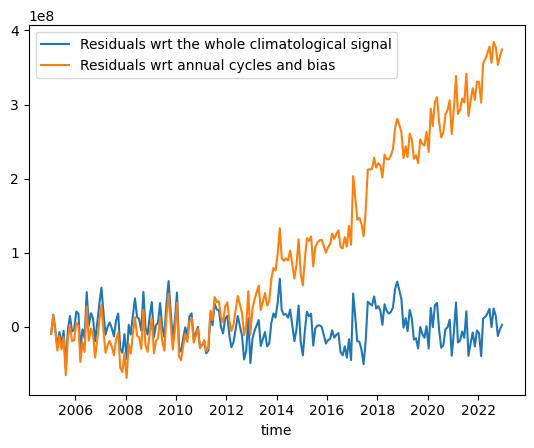

In [14]:
clim=moheacan.lntime.Coeffs_climato(order=3)
clim_gohc = clim.solve('gohc')
clim_gohc.residuals().plot(label='Residuals wrt the whole climatological signal')
clim_gohc.residuals(coefficients=['sinAnnual','cosAnnual','sinSemiAnnual','cosSemiAnnual','order_0']).plot(label='Residuals wrt annual cycles and bias')
plt.legend()

## Generation of a Signal and Interpolation
The *signal* method allows generating the original signal by:
- including the coefficients of the desired climate signal components,
- interpolating the NaN values in the residuals of the original signal using an interpolation method available in `scipy.interp1d`,
- interpolating at dates different from those of the original signal (no extrapolation possible).

(Note: This last interpolation feature does not work if the climate functions take arguments other than time as input, since that would require multi-dimensional interpolation, which is beyond the scope of this class.)


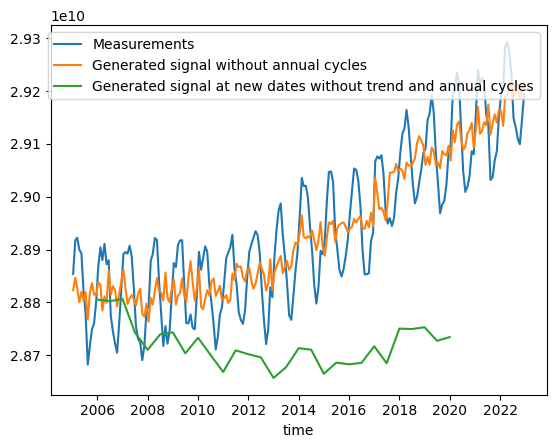

In [15]:
moheacan.gohc.plot(label='Measurements')

clim=moheacan.lntime.Coeffs_climato(order=1)
clim_gohc = clim.solve('gohc')
clim_gohc.signal(coefficients=['order_0','order_1']).plot(label='Generated signal without annual cycles')
t_new=xr.DataArray(pd.date_range('2006','2020',freq='6MS'),dims='time')
clim_gohc.signal(x=t_new,coefficients=['order_0']).plot(label='Generated signal at new dates without trend and annual cycles')
plt.legend()

Example of Interpolation by Setting Two Years of Measurements to NaN.

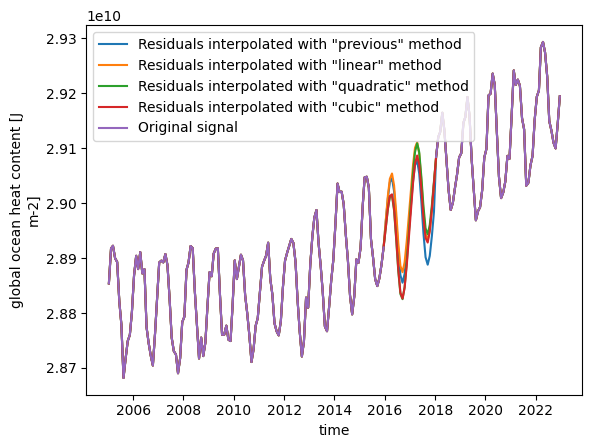

In [16]:
trous=moheacan.where((moheacan.time<pd.to_datetime('2016'))|(moheacan.time>pd.to_datetime('2018')))
clim=trous.lntime.Coeffs_climato(order=2)
clim_gohc = clim.solve('gohc')

# Reconstructed Signal with All Climatology Components, Residuals Interpolated Using Various Methods
clim_gohc.signal(method='previous').plot(label='Residuals interpolated with "previous" method')
clim_gohc.signal(method='linear').plot(label='Residuals interpolated with "linear" method')
clim_gohc.signal(method='quadratic').plot(label='Residuals interpolated with "quadratic" method')
clim_gohc.signal(method='cubic').plot(label='Residuals interpolated with "cubic" method')

trous.gohc.plot(label='Original signal')
plt.legend()

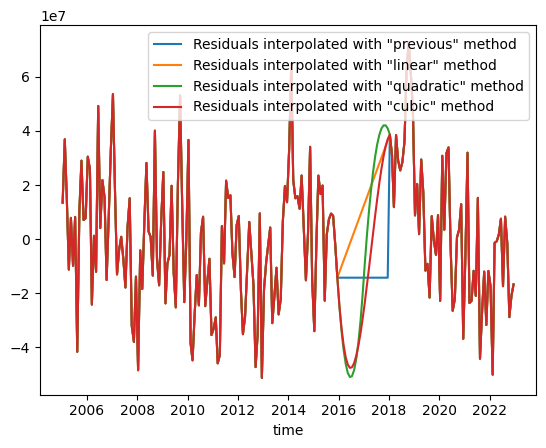

In [17]:
# Residuals Only, Interpolated Using Various Methods

clim_gohc.signal(coefficients=[],method='previous').plot(label='Residuals interpolated with "previous" method')
clim_gohc.signal(coefficients=[],method='linear').plot(label='Residuals interpolated with "linear" method')
clim_gohc.signal(coefficients=[],method='quadratic').plot(label='Residuals interpolated with "quadratic" method')
clim_gohc.signal(coefficients=[],method='cubic').plot(label='Residuals interpolated with "cubic" method')

plt.legend()

## Climatology on a Grid
With multiple dimensions, the principle is exactly the same. The calculation is distributed for each point on the grid, resulting in a grid of coefficients.  
The following example shows how to plot the trend of OHC.


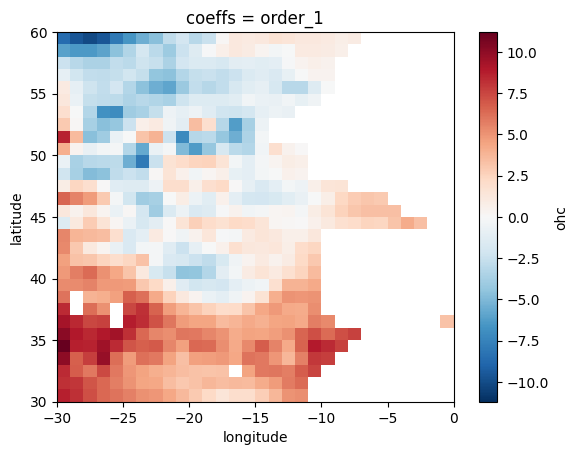

In [20]:
clim=moheacan.lntime.Coeffs_climato(order=1)
clim_ohc = clim.solve('ohc')
clim_ohc.result.sel(coeffs='order_1').plot()

## Climatology on Irregular Points
The example dataset is the ocean heat content between 0 and 680m depth, in the North Atlantic, between -20 and -10 degrees longitude and 40 and 50 degrees latitude.  
Measurements are taken between 2004 and 2024, each characterized by its date, position, and heat content.  
A clear gradient is visible depending on latitude.

<xarray.Dataset> Size: 260kB
Dimensions:    (N_PROF: 8124)
Dimensions without coordinates: N_PROF
Data variables:
    latitude   (N_PROF) float64 65kB ...
    longitude  (N_PROF) float64 65kB ...
    time       (N_PROF) datetime64[ns] 65kB ...
    ohc        (N_PROF) float64 65kB 3.301e+10 3.092e+10 ... 3.439e+10 3.549e+10

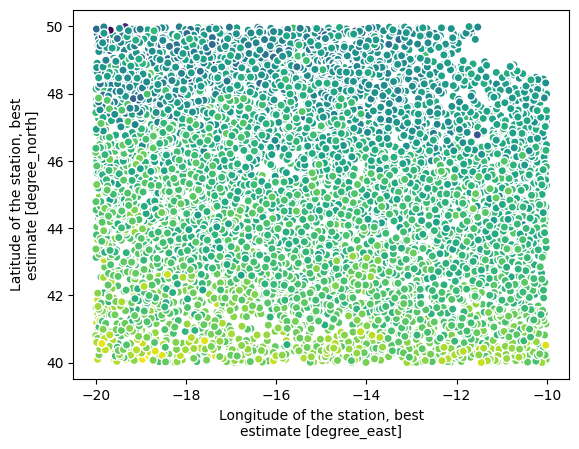

In [21]:
argo=xr.open_dataset('../../data/argo.nc')
argo.plot.scatter(x='longitude',y='latitude',c=argo.ohc)
argo

To compute a heat climatology in this area, you need to specify the dimension along which to perform the calculations (*N_PROF*) and the name of the variable containing the date (*time*).

In [22]:
clim=argo.lntime.Coeffs_climato(dim='N_PROF',var='time')
clim_ohc = clim.solve('ohc')

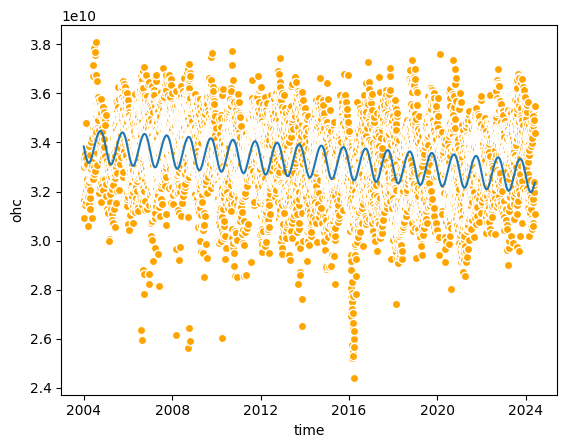

In [23]:
plt.plot(argo.time,clim_ohc.climatology())
argo.plot.scatter(x='time',y='ohc',c='orange')

This climatology does not account for the latitude gradient; the measurements are very scattered and the residuals are large.

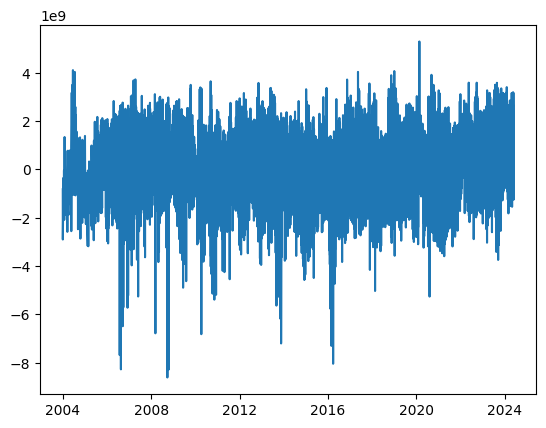

In [24]:
plt.plot(argo.time,clim_ohc.residuals())

A regression can be performed on the deviation in latitude and longitude relative to the center of the area.

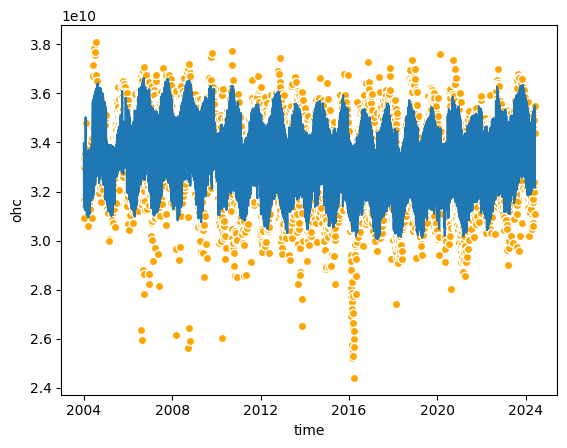

In [25]:
def f(X):
    return X

clim2=argo.lntime.Coeffs_climato(dim='N_PROF',var='time',order=3)
clim2.add_coeffs('GradLat',f,'latitude',ref=45,scale=1.)
clim2.add_coeffs('GradLon',f,'longitude',ref=-15,scale=1.)
clim_ohc2 = clim2.solve('ohc')

plt.plot(argo.time,clim_ohc2.climatology())
argo.plot.scatter(x='time',y='ohc',c='orange')

We can see that the climatology including the positional gradient better reflects reality, and the residuals are smaller.

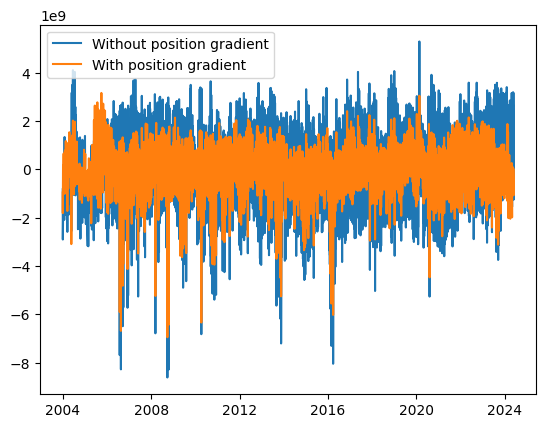

In [26]:
plt.plot(argo.time,clim_ohc.residuals(),label='Without position gradient')
plt.plot(argo.time,clim_ohc2.residuals(),label='With position gradient')
plt.legend()

The residuals are much closer to white noise.

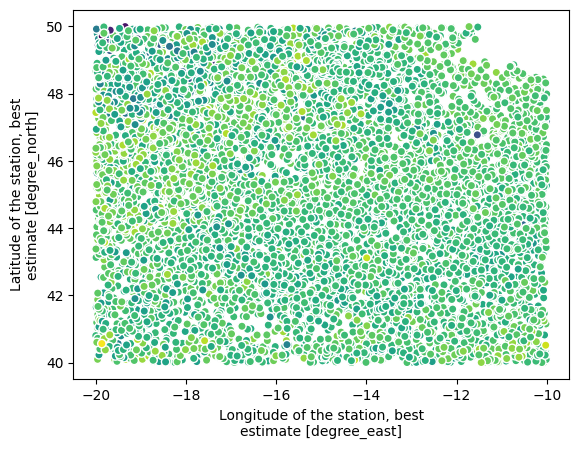

In [27]:
argo.plot.scatter(x='longitude',y='latitude',c=clim_ohc2.residuals())

It is also possible, when calculating the climatology at a point, to add weights based on the distance from the measurement to that point.

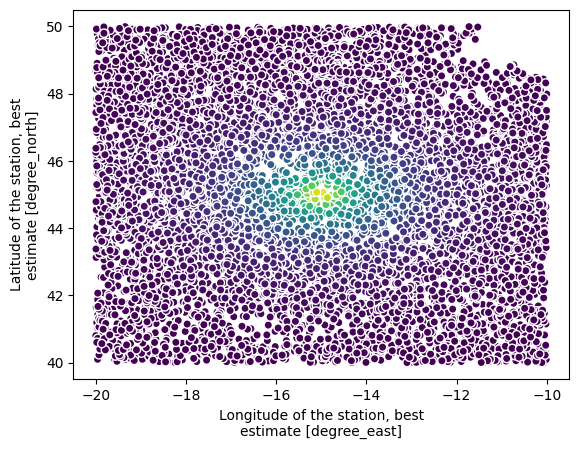

In [28]:
# Calculation of the Weighting Function and Plotting the Weights for All Measurement Points
sig_dist=100000.
centre=xr.DataArray(data=0,dims=['latitude','longitude'],coords=dict(latitude=[45],longitude=[-15]))
dist=centre.lngeo.distance(argo).squeeze().drop_vars(['latitude','longitude'])
poids=np.exp(-(dist/sig_dist))
argo['poids']=poids/poids.sum('N_PROF')
arg=argo.sortby(poids)
argo.plot.scatter(x='longitude',y='latitude',c=poids)

The climatology is solved by applying the weighting function to each measurement, and the climatological signal is calculated on a regular time series.  
Note that the *climatology* method must be passed a dataset containing all coordinates needed for calculating the functions to fit, namely *time*, *latitude*, and *longitude*.

<xarray.Dataset> Size: 6kB
Dimensions:    (time: 241)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2024-01-01
Data variables:
    latitude   (time) float64 2kB 45.0 45.0 45.0 45.0 ... 45.0 45.0 45.0 45.0
    longitude  (time) float64 2kB -15.0 -15.0 -15.0 -15.0 ... -15.0 -15.0 -15.0

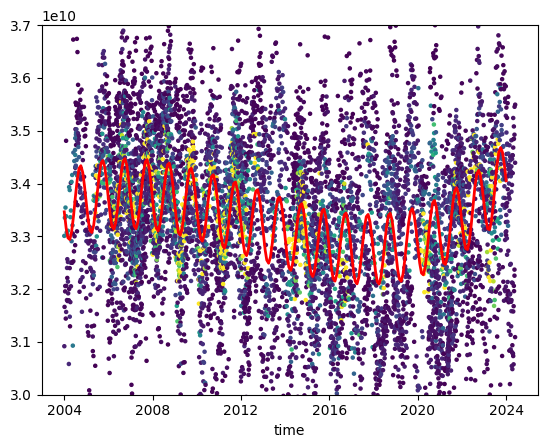

In [29]:
clim_ohc2 = clim2.solve('ohc',weight=poids)

plt.scatter(x=argo.time,y=argo.ohc,c=argo.poids,s=5,vmax=0.0005)

t=xr.Dataset(coords=dict(time=pd.date_range('2004','2024',freq='1MS')))
z=xr.zeros_like(t.time.astype(float))
t_new=xr.Dataset(dict(latitude=z+45,longitude=z-15))
clim_ohc2.climatology(x=t_new,coefficients=['order_0','order_1','order_2','order_3','cosAnnual','sinAnnual']).plot(lw=2,c='r')
plt.ylim([3e10,3.7e10])
t_new


In [30]:
clim_ohc2.result.to_netcdf('climato_sparse.nc')

## Using Climatology Coefficients Independently of the Original Signal
For example, if the "result" attribute of the `Climato` instance has been saved, you might want to recreate a signal after reloading these coefficients. To do this, you need to know all the parameters used to generate this climatology:
- the names of the coefficients
- the names of the associated functions
- the names of the variables for the functions
- the reference and scaling
- any additional parameters to pass to the function (e.g., the order for the polynomial to regress)

You need to import the *Generate_climato* class from *lenapy.utils.climato*, initialize it with the coefficients (the saved *result* field), and add the regression functions just like with the `Climato` class.  
By default, as with the `Climato` class, the annual and semi-annual cycles, as well as the mean and trend, are added with a default reference which will be the minimum date of the time series on which the signal is calculated. If you do not want these default functions, specify `cycle=False` and/or `order=-1` when calling the class.

Then call *climatology* exactly as with the `Climato` instance, except that it is mandatory to specify the vector on which to calculate the signal. This vector is a dataset or data array containing the variables necessary for executing the climatology functions (usually *time*).

It is not mandatory to assign a function to all present coefficients; in that case, only the coefficients for which a function has been defined will be calculated.

In [31]:
clim_saved=xr.open_dataset('climato_sparse.nc')
clim_saved

<xarray.Dataset> Size: 600B
Dimensions:  (coeffs: 10)
Coordinates:
  * coeffs   (coeffs) <U13 520B 'cosAnnual' 'sinAnnual' ... 'GradLat' 'GradLon'
Data variables:
    ohc      (coeffs) float64 80B ...

In [32]:
from lenapy.utils.climato import Signal_climato
# An instance is created with the annual cycle functions and without polynomial regression. (var and cycle are unnecessary as they are the default values)
generate = Signal_climato(clim_saved, var='time', cycle=True, order=-1)
# For educational purposes, to add a polynomial function, use the add_coeffs method specifying:
#  - the names of the coefficients concerned in "clim_saved"
#  - the name of the function to apply (pol)
#  - the name of the variable on which to apply the function
#  - the reference (None: this will be the minimum value of the variable on which to calculate the signal) (not needed here as it is the default if absent)
#  - the scaling (not needed here as it is the default if absent)
#  * additional parameters for the function (the polynomial order)
generate.add_coeffs(['order_%i'%i for i in np.arange(4)],pol,'time', ref=None, scale=pd.to_timedelta("1D").asm8, order=3)

# No function has been defined for gradLat and gradLon; these coefficients will not be used in the output signal.

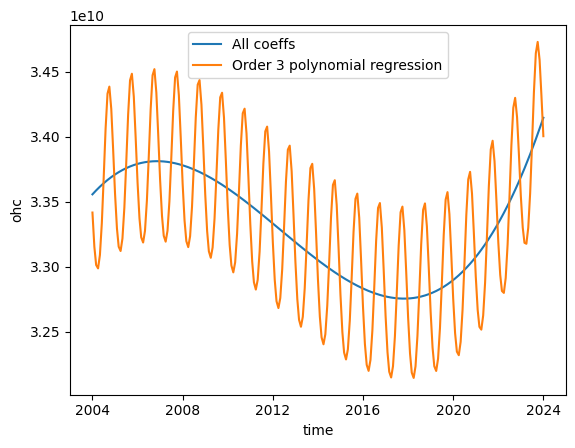

In [33]:
generate.climatology(x=t_new,coefficients=['order_0','order_1','order_2','order_3']).ohc.plot(label='All coeffs')
generate.climatology(x=t_new).ohc.plot(label='Order 3 polynomial regression')
plt.legend()

## Ascending Compatibility

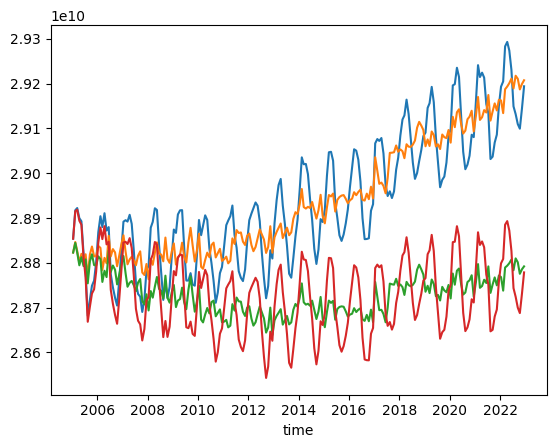

In [34]:
moheacan.gohc.plot(label='Measurements')
moheacan.gohc.lntime.climato().plot()
moheacan.gohc.lntime.climato(trend=False).plot()
moheacan.gohc.lntime.climato(trend=False,cycle=True).plot()